In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import openpyxl 
import os

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.metrics import r2_score
from scipy import stats
import csv
import statsmodels.api as sm

In [3]:
from load_data import load_time_series_data
from load_data import load_categorical_data
from load_data import load_categorical_more_data

In [4]:
categorical_data,local_authority_names,total_duty_owed,total_population_in_households,prevention_duty_owed,relief_duty_owed,support_need_homeless,no_longer_homeless,homeless_real_value,categorical_waiting_list_size,social_housing_lettings_2021,band_A_B_properties,band_C_D_properties,band_E_F_properties,band_G_H_properties,median_prices,median_earning_gross,categorical_median_afforability_ratio,lower_quatile_prices,lower_quatile_earning_gross,categorical_lower_quatile_afforability_ratio = load_categorical_data()

In [5]:
affordableRent_start,social_housing_start,intermediate_start,total_affordable_start,affordable_complete,social_complete,intermediate_complete,total_affordable_complete=load_categorical_more_data()

In [6]:
def MinMaxNormal(df):
    normalized_df=(df-df.min())/(df.max()-df.min())
    return normalized_df

In [7]:
def denormal(normalized_df,original_df):
    df = (normalized_df*(original_df.max()-original_df.min()))
    df+=original_df.min()
    return df

In [8]:
def mean_absolute_percentage_error(y_true, y_pred): 
    MSPE = mean_squared_error(y_true,y_pred,squared = True)/np.mean(y_true) * 100
    return np.abs(MSPE)

In [10]:
def R2test(test_set,value_set):
    results = []
    for i in  range(len(value_set[0,:])):
        R2 = r2_score(test_set,value_set[:,i])
        results.append(R2)
    return results

In [11]:
def produce_predictions_linear_regression(train_X, test_X, train_y, test_y):
    # data fitting
    model = LinearRegression().fit(train_X, train_y)
    # make predictions
    predictions = model.predict(test_X)
    return predictions,model

In [12]:
# features include duty owed
affordable_housing_stats = pd.DataFrame([total_duty_owed,\
                  total_population_in_households,\
                  support_need_homeless,\
                  categorical_waiting_list_size,\
                  social_housing_lettings_2021,band_A_B_properties,\
                  band_C_D_properties,band_E_F_properties,band_G_H_properties,\
                  median_prices,median_earning_gross,categorical_median_afforability_ratio,\
                  lower_quatile_prices,lower_quatile_earning_gross,\
                  categorical_lower_quatile_afforability_ratio,\
                  affordableRent_start,social_housing_start,\
                  intermediate_start,total_affordable_start,\
                  affordable_complete,social_complete,intermediate_complete,\
                  total_affordable_complete])

In [13]:
# Create new training attributes conbining all values
affordable_housing_stats = pd.DataFrame([total_population_in_households,\
                  support_need_homeless,\
                  categorical_waiting_list_size,\
                  social_housing_lettings_2021,band_A_B_properties,\
                  band_C_D_properties,band_E_F_properties,band_G_H_properties,\
                  median_prices,median_earning_gross,categorical_median_afforability_ratio,\
                  lower_quatile_prices,lower_quatile_earning_gross,\
                  categorical_lower_quatile_afforability_ratio,\
                  affordableRent_start,social_housing_start,\
                  intermediate_start,total_affordable_start,\
                  affordable_complete,social_complete,intermediate_complete,\
                  total_affordable_complete])
affordable_housing_stats = affordable_housing_stats.transpose()

In [14]:
train_relief_1, test_relief_1, train_real_hl, test_real_hl = train_test_split(relief_duty_owed, homeless_real_value, test_size=0.2, random_state=0,)

In [15]:
train_affordable, test_affordable, train_real_hl_1, test_real_hl_1 = train_test_split(affordable_housing_stats, homeless_real_value, test_size=0.2, random_state=0,)

In [16]:
affordable_housing_stats.columns

Index(['Number of households in area4 (000s)',
       'Total households with support needs',
       'Size_of_social_housing_waiting_list_2021', '2021 Total Lettings',
       'A_B_property_counts', 'C_D_property_counts', 'E_F_property_counts',
       'G_H_property_counts', 'median_houses_2020', 'median_earning_2020',
       'ratio_by_medians_2020', 'lower_quatile_houses_2020',
       'lower_quatile_earning_2020', 'ratio_by_lower_quatile_2020',
       'Affordable Rent (Starts on Site)', 'Social Rent (Starts on Site)',
       'Intermediate Rent (Starts on Site)',
       'Total Affordable (Starts on Site)', 'Affordable Rent (Completions)',
       'Social Rent (Completions)', 'Intermediate Rent (Completions)',
       'Total Affordable (Completions)'],
      dtype='object')

In [17]:
# normalization
train_affordable_norm = MinMaxNormal(train_affordable)
test_affordable_norm = MinMaxNormal(test_affordable)
train_real_hl_1_norm = MinMaxNormal(train_real_hl_1)
test_real_hl_1_norm = MinMaxNormal(test_real_hl_1)


In [18]:
# Relief Duty Against Affordable Housing Completetions
affHousing_predictions,manymany_model = produce_predictions_linear_regression(train_affordable_norm, test_affordable_norm, train_real_hl_1_norm, test_real_hl_1_norm)
affHousing_predictions = pd.DataFrame(affHousing_predictions)
affHousing_predictions = denormal(affHousing_predictions,test_real_hl_1)

In [19]:
example_mlr_scores = pd.DataFrame(manymany_model.coef_)
example_mlr_scores.columns = ['Scores']
example_mlr_scores.index = list(affordable_housing_stats.columns[:])
cwd = os.getcwd()
example_mlr_scores.to_csv(os.path.join(cwd, "ResultTables/example_mlr_model_scores.csv"))  

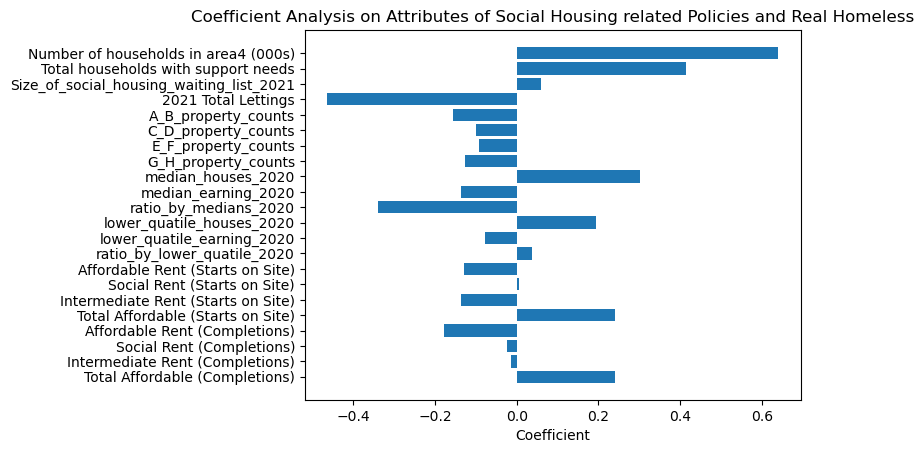

In [20]:
# Fixing random state for reproducibility
np.random.seed(0)
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
x_names = list(affordable_housing_stats.columns[:])
y_pos = np.arange(len(x_names))

ax.barh(y_pos, example_mlr_scores['Scores'].values, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_yticks(y_pos)
ax.set_yticklabels(list(x_names))
ax.set_xlabel('Coefficient')
ax.set_title('Coefficient Analysis on Attributes of Social Housing related Policies and Real Homeless')
plt.savefig('Figure/mlr_Coefficient_analysis.png')
plt.show()

In [30]:
r2_affordable_to_hl = r2_score(np.array(test_real_hl_1),np.array(affHousing_predictions[0]),sample_weight=None)
print('R^2 for all to ended-up homeless: '+str(r2_affordable_to_hl))

R^2 for all to ended-up homeless: 0.6589981355144413


In [31]:
# calculate coefficient matrix
coef = np.corrcoef(np.array(affHousing_predictions[0]).astype(int), np.array(test_real_hl_1).astype(int))
print(coef[0,1])

0.8193166591464974


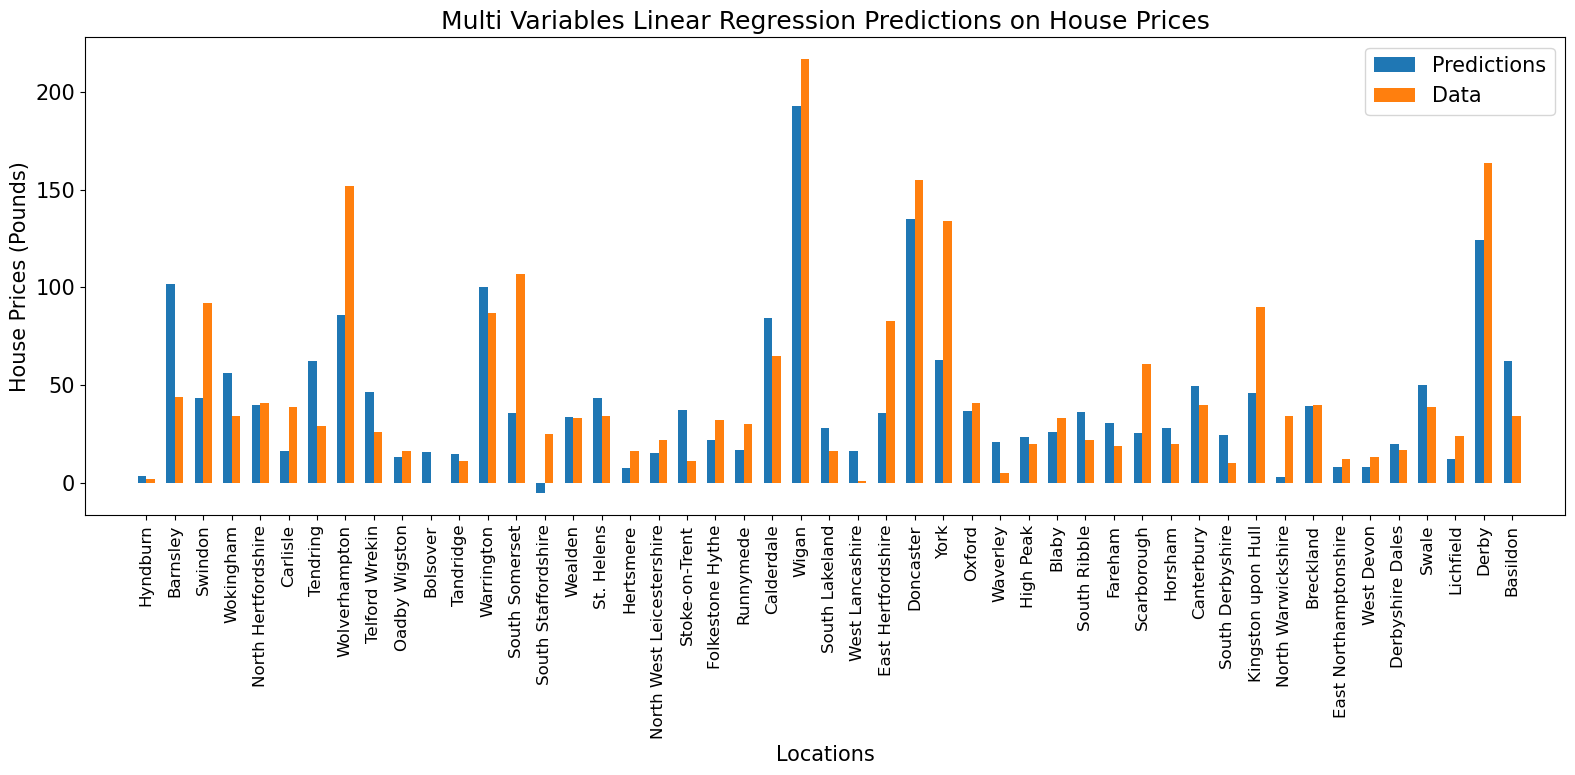

In [22]:
f_predictions = affHousing_predictions
test_y = test_real_hl_1

N =len(f_predictions)
locations = range(1,N+1)

# Position of bars on x-axis
y_pos = np.arange(N)

# Width of a bar 
width = 0.3
# Plotting
plt.rcParams.update({'font.size': 15})
fig_r2, ax = plt.subplots(figsize=(16,8))
plt.bar(y_pos, f_predictions[0], width, label='Predictions')
plt.bar(y_pos + width, test_y, width, label='Data')
plt.xlabel('Locations')
plt.ylabel('House Prices (Pounds)')
plt.title('Multi Variables Linear Regression Predictions on House Prices')

# xticks()
plt.xticks(y_pos + width / 2, list(local_authority_names[test_y.index]))
plt.setp(ax.get_xticklabels(), fontsize=12, rotation='vertical')
# Size of the Plot
plt.xlim([-2,max(y_pos)+2])
# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('Figure/full_prediction_plots.png')
plt.show()